<a href="https://colab.research.google.com/github/shyoonCS/DataAnalysis/blob/main/202534_364010(%EC%9C%A4%EC%84%A0%ED%9D%AC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2025학년도 2학기 출석수업 과제물(온라인 제출)
* 교과목명 : <span style="color:blue"> **딥러닝**</span>
* 학  번 : 202534-364010
* 성  명 : 윤선희
* 연락처 : 010-6232-4338
---



코드1-1[1] 필요한 패키지 불러오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

코드1-1[2] 데이터 준비 함수 정의하기

In [2]:
def prepare_data(target):
    iris = load_iris()          # iris data set 읽기
    X_tr = iris.data[:, 2:]     # 4개의 특징 중 꽃잎의 길이와 폭 선택(3번째, 4번째)
    labels = iris.target_names  # 'setosa', 'versicolor', 'virginica'
    y = iris.target

    # 학습표본의 레이블 지정 - target에 지정된 레이블이면 1, 그 외는 0
    y_tr = []
    for i in range(150):
        y_tr.append(labels[y[i]] == target)
    y_tr = np.array(y_tr, dtype=int)
    return X_tr, y_tr, ['(1) '+target, '(0) the others']

코드1-1[3] 활성함수 - 단위 계단 함수

In [3]:
# 활성 함수 - 단위 계단 함수
def step(x):
    return int(x >= 0)

코드1-1[4] 퍼셉트론 객체를 만들기 위한 클래스 선언하기

In [4]:
class Perceptron():
    def __init__(self, dim, activation):
        rnd = np.random.default_rng()
        self.dim = dim #입력층 입력의 수(특징 개수 -> 길이와 폭 2개)
        self.activation = activation
        # 가중치(w)와 바이어스(b)를 He normal 방식으로 초기화
        self.w = rnd.normal(scale = np.sqrt(2.0 / dim), size=dim)
        self.b = rnd.normal(scale = np.sqrt(2.0 / dim))

    def printW(self):
        for i in range(self.dim):
            print('  w{} = {:6.3f}'.format(i+1, self.w[i]), end='')
        print('  b = {:6.3f}'.format(self.b))

    def predict(self, x):  # numpy 배열 x에 저장된 표본의 출력 계산
        return np.array([self.activation(np.dot(self.w, x[i]) + self.b)
                          for i in range(len(x))])

    def fit(self, X, y, N, epochs, eta=0.01):
        # 학습표본의 인덱스를 무작위 순서로 섞음
        idx = list(range(N))
        np.random.shuffle(idx)
        X = np.array([X[idx[i]] for i in range(N)])
        y = np.array([y[idx[i]] for i in range(N)])

        f = 'Epochs = {:4d}    Loss = {:8.5f}'
        print('w의 초깃값  ', end='')
        self.printW()
        for j in range(epochs):
            for i in range(N):
                # x[i]에 대한 출력 오차 계산
                delta = self.predict([X[i]])[0] - y[i]
                self.w -= eta * delta * X[i] #가중치 w 업데이트
                self.b -= eta * delta        #바이어스 b 업데이트
            # 학습 과정 출력
            if j < 10 or (j+1) % 100 == 0:
                loss = self.predict(X) - y
                loss = (loss * loss).sum() / N #MSE 평균 제곱 오차 계산
                print(f.format(j+1, loss), end='')
                self.printW()

코드1-1[5] 모델 시각화

In [33]:
def visualize(net, X, y, multi_class, labels, class_id, colors,xlabel, ylabel, legend_loc='lower right', title=''):
    # 데이터의 최소~최대 범위를 0.05 간격의 좌표값으로 나열
    x_max = np.ceil(np.max(X[:, 0])).astype(int)
    x_min = np.floor(np.min(X[:, 0])).astype(int)
    y_max = np.ceil(np.max(X[:, 1])).astype(int)
    y_min = np.floor(np.min(X[:, 1])).astype(int)
    x_lin = np.linspace(x_min, x_max, (x_max-x_min)*20+1)
    y_lin = np.linspace(y_min, y_max, (y_max-y_min)*20+1)

    # x_lin과 y_lin의 격자좌표의 x와 y 값 구하기
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)

    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])

    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = net.predict(X_test)
        y_hat = np.array([np.argmax(y_hat[k])
                            for k in range(len(y_hat))], dtype=int)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
        y_hat = y_hat.reshape(len(y_hat))

    # 출력할 그래프의 수평/수직 범위 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 클래스별로 산점도 그리기
    for c, i, c_name in zip(colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                     c = c, s = 5, alpha = 0.3, edgecolors = 'none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y == i, 0], X[y == i, 1],
                     c = c, s = 20, label=c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc=legend_loc)

    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.show()

코드1-1[6] 훈련 데이터 준비하기

In [24]:
nSamples = 150
nDim = 2 #꽃잎의 길이와 너비
target = 'setosa' #식별하고자 하는 붓꽃 종류 지정
X_tr, y_tr, labels = prepare_data(target)

코드1-1[7] 퍼셉트론 객체 생성 및 학습

In [25]:
p = Perceptron(nDim, activation=step)
p.fit(X_tr, y_tr, nSamples, epochs=1000, eta=0.01)

w의 초깃값    w1 =  1.259  w2 =  0.056  b = -1.984
Epochs =    1    Loss =  0.71333  w1 =  0.486  w2 = -0.316  b = -1.764
Epochs =    2    Loss =  0.66000  w1 =  0.448  w2 = -0.447  b = -1.394
Epochs =    3    Loss =  0.49333  w1 =  0.388  w2 = -0.574  b = -1.034
Epochs =    4    Loss =  0.64667  w1 =  0.372  w2 = -0.678  b = -0.674
Epochs =    5    Loss =  0.40667  w1 =  0.306  w2 = -0.795  b = -0.324
Epochs =    6    Loss =  0.12000  w1 =  0.253  w2 = -0.843  b = -0.124
Epochs =    7    Loss =  0.07333  w1 =  0.226  w2 = -0.852  b = -0.034
Epochs =    8    Loss =  0.06667  w1 =  0.232  w2 = -0.847  b =  0.026
Epochs =    9    Loss =  0.03333  w1 =  0.211  w2 = -0.848  b =  0.066
Epochs =   10    Loss =  0.03333  w1 =  0.200  w2 = -0.847  b =  0.096
Epochs =  100    Loss =  0.00000  w1 =  0.122  w2 = -0.811  b =  0.296
Epochs =  200    Loss =  0.00000  w1 =  0.122  w2 = -0.811  b =  0.296
Epochs =  300    Loss =  0.00000  w1 =  0.122  w2 = -0.811  b =  0.296
Epochs =  400    Loss =  0.000

코드1-1[8] 특징 공간 결정 영역 시각화

In [ ]:
# 학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.
visualize(p, X_tr, y_tr,
          multi_class = False,
          class_id = labels,
          labels = [1, 0],
          colors = ['magenta', 'blue'],
          xlabel = 'petal length',
          ylabel = 'petal width',
          legend_loc = 'upper left',
          title = 'Sample')

##<span style="color:blue"> **▶  주관식 1**</span>

1-1. 학습데이터 생성
* 평균이 다른 두개 클래스 데이터를 랜덤하게 생성(0 또는 1)
* rnd.normal() : 평균 0, 표준편차 0.2인 2차원 난수 벡터를 생성하여 데이터 생성

In [112]:
def prepare_data_1(N) :
  # N : 학습표본 수, 클래스 0의 평균 좌표 (1,2), 클래스 1의 평균 좌표(2,1)
  C = np.array([[1,2], [2,1]])
  X = []
  y = []
  rnd = np.random.default_rng()
  #각 클래스의 평균 좌표에 무작위 값을 더하여 학습표본 집합 생성
  for i in range(N) :
    j = rnd.integers(0,  2)
    x = np.array(rnd.normal(loc=0.0, scale=0.2, size=2)) + C[j]
    X.append(x)
    y.append(j)
  return np.array(X), np.array(y), ['Class 0', 'Class 1']

1.2. 코드 1-1[6] 수정
* 훈련데이터 준비(표본 : 100개)

In [113]:
nDim = 2
X_tr, y_tr, labels = prepare_data_1(100)
nSamples = len(X_tr)

1.3. 코드 1-1[7] 수정
* 퍼셉트론 객체 생성 및 학습(학습 반복횟수 : 500회,학습률(Learning Rate) : 0.1-> 0.5로 수정하여 빠르게 학습)
* 활성함수 : **계단함수**(입력값이 0 이상이면 1, 0 미만이면 0을 출력하는 함수), 출력을 0과 1로 **이진분류(classification)**

In [114]:
p = Perceptron(nDim, activation=step)
p.fit(X_tr, y_tr, nSamples, epochs=500, eta=0.05)

w의 초깃값    w1 = -0.594  w2 = -1.117  b = -1.248
Epochs =    1    Loss =  0.02000  w1 =  0.748  w2 = -0.457  b = -0.598
Epochs =    2    Loss =  0.02000  w1 =  0.760  w2 = -0.465  b = -0.598
Epochs =    3    Loss =  0.02000  w1 =  0.773  w2 = -0.473  b = -0.598
Epochs =    4    Loss =  0.00000  w1 =  0.786  w2 = -0.482  b = -0.598
Epochs =    5    Loss =  0.00000  w1 =  0.786  w2 = -0.482  b = -0.598
Epochs =    6    Loss =  0.00000  w1 =  0.786  w2 = -0.482  b = -0.598
Epochs =    7    Loss =  0.00000  w1 =  0.786  w2 = -0.482  b = -0.598
Epochs =    8    Loss =  0.00000  w1 =  0.786  w2 = -0.482  b = -0.598
Epochs =    9    Loss =  0.00000  w1 =  0.786  w2 = -0.482  b = -0.598
Epochs =   10    Loss =  0.00000  w1 =  0.786  w2 = -0.482  b = -0.598
Epochs =  100    Loss =  0.00000  w1 =  0.786  w2 = -0.482  b = -0.598
Epochs =  200    Loss =  0.00000  w1 =  0.786  w2 = -0.482  b = -0.598
Epochs =  300    Loss =  0.00000  w1 =  0.786  w2 = -0.482  b = -0.598
Epochs =  400    Loss =  0.000

1.4. 코드 1-1[8]  시각화 옵션 수정<br>
* <span style="color:blue"> **[분석결과]** : 단층 퍼셉트론을 통하여 두개 클래스를 하나의 선형 경계로 분류 가능 </span>

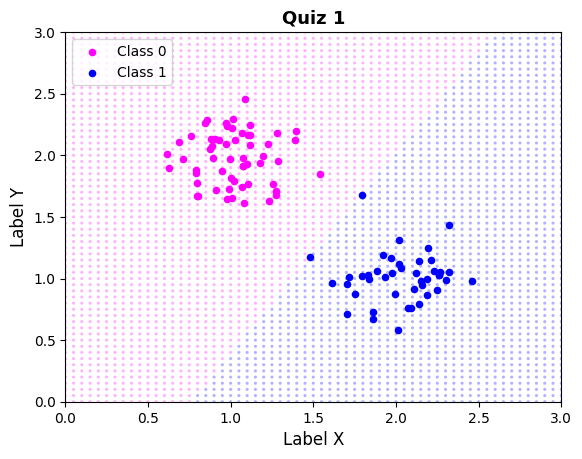

In [115]:
visualize(p, X_tr, y_tr,
          multi_class = False,
          class_id = labels,
          labels = [0, 1],
          colors = ['magenta', 'blue'],
          xlabel = 'Label X',
          ylabel = 'Label Y',
          legend_loc = 'upper left',
          title = 'Quiz 1')

##<span style="color:blue"> **▶주관식 2**</span>

2-1. 학습데이터 생성
* 두개의 클래스가 X자 형태로 교차되는 데이터

In [59]:
def prepare_data_2(N) :
  # N : 학습표본 수, 클래스 0의 평균 좌표 (1,2),(2,1) 클래스 1의 평균 좌표(1,1),(2,2)
  C = np.array([[1,2], [2,1],[1,1],[2,2]])
  X = []
  y = []
  rnd = np.random.default_rng()
  #각 클래스의 평균 좌표에 무작위 값을 더하여 학습표본 집합 생성
  for i in range(N) :
    j = rnd.integers(0,  4)
    x = np.array(rnd.normal(loc=0.0, scale=0.2, size=2)) + C[j]
    X.append(x)
    y.append(j // 2)
  return np.array(X), np.array(y), ['Class 0', 'Class 1']

2.2. 코드 1-1[6] 수정
* 훈련데이터 준비(표본 : 100개)

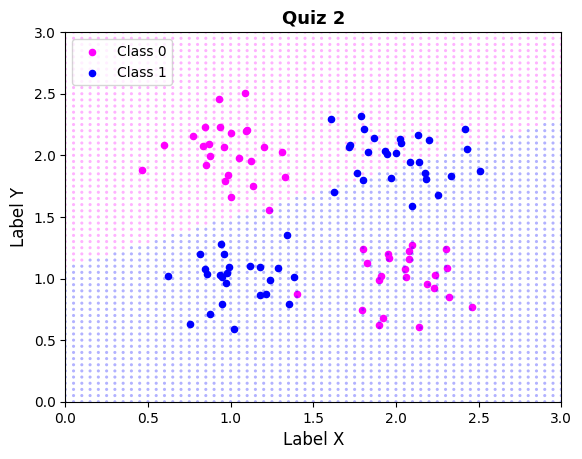

In [60]:
nDim = 2
X_tr, y_tr, labels = prepare_data_2(100)
nSamples = len(X_tr)

2.3. 코드 1-1[7] 수정
* 퍼셉트론 객체 생성 및 학습(학습 반복횟수 : 1000회,학습률(Learning Rate) : 0.1-> 0.5로 수정하여 빠르게 학습)
* 활성함수 : **계단함수**(입력값이 0 이상이면 1, 0 미만이면 0을 출력하는 함수), 출력을 0과 1로 **이진분류(classification)**

In [ ]:
p = Perceptron(nDim, activation=step)
p.fit(X_tr, y_tr, nSamples, epochs=1000, eta=0.05)

2.4. 코드 1-1[8]  시각화 옵션 수정<br>
* <span style="color:blue"> **[분석결과]** : 단층 퍼셉트론(하나의 선형 경계)로는 해당 데이터 클래스 </span> <span style="color:red"> <u>분류 불가(XOR 연산문제)</u></span><br>
* <span style="color:blue">**[해결방안]** : 다중퍼셉트론(MLP)을 통하여 해결(Hidden Layer추가하여 XOR 연산문제 해결 가능)
</span>

In [ ]:
visualize(p, X_tr, y_tr,
          multi_class = False,
          class_id = labels,
          labels = [0, 1],
          colors = ['magenta', 'blue'],
          xlabel = 'Label X',
          ylabel = 'Label Y',
          legend_loc = 'upper left',
          title = 'Quiz 2')